In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
%matplotlib inline

In [2]:
def NGD(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
# NGD orignal model with constant time memory
def NGD_const(x,alpha,tau_NGD,K):
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for k in range(len(T)-1):
        if T[k]>tau_NGD:
            F=y[k-int(tau_NGD/dt)]
        else:
            F=0
        dy=dt*(-alpha*y[k]+K*(x[k]-F))
        y[k+1]=y[k]+dy
    return y,z

In [4]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [6]:
def FFT_quick(data):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(x), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

(150.0, 152.0)

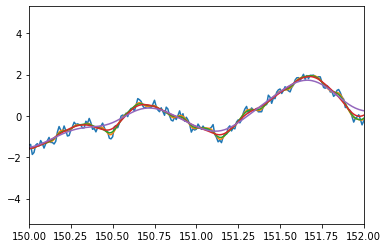

In [7]:
# generate OU
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=1
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering
fc=[10,7,4,2]
x_set=[L]
for ifc in range(len(fc)):
    b, a = signal.butter(2, 2*fc[ifc]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    x_set.append(Lf)
    
for i in range(np.size(x_set,0)):
    plt.plot(T,x_set[i])
plt.xlim(150,152)

# load experiment OU stimulus data
path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/'

# file=['OU_tau=100ms_19-Apr-2020_0_sort_unit1.mat','OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#       'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#      'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat','OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat']

file=['OU_tau=600ms_19-Apr-2020_0_sort_unit1.mat','OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
      'OU_tau=600ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
     'OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat','OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat']

# file=['OU_tau=1000ms_19-Apr-2020_0_sort_unit1.mat','OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#       'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#      'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat','OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat']

fc=[10,7,4,2]

sti_set=[[] for k in range(len(file))]
samp_rate=20000
dt=0.01
b, a = signal.butter(2, 2*50/samp_rate, btype='low', analog=False) # remove noise
x_set=[[] for k in range(len(file))]
for i in range(len(file)):
    stidata=loadmat(path+file[i])
    TimeStamps=stidata['TimeStamps']
    sti=stidata['a_data']
    sti_fil = signal.filtfilt(b, a, sti[0])
    sti1=sti_fil[0:-1:200]
    T_total=np.arange(1,len(sti1)+0.0001)*dt
    x=sti1[(T_total>TimeStamps[0][0]) & (T_total<TimeStamps[0][1])]
    x=x-np.mean(x)
    x_set[i]=x
xlen=[len(x_set[k]) for k in range(len(x_set))]
x_set=[x_set[k][:min(xlen)] for k in range(len(x_set))]
T=np.arange(1,np.size(x_set,1)+0.0001)*dt

In [8]:
y_set=[[] for i in range(len(x_set))]
z_set=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    y_set[i],z_set[i]=NGD(x_set[i],40,5,18,10,1)
#     y_set[i],z_set[i]=NGD(x_set[i],8,1.4,37,10,1)

In [9]:
# # same scale
# for i in range(np.size(x_set,0)):
#     x_set[i]=x_set[i]/np.std(x_set[i])
#     y_set[i]=y_set[i]/np.std(y_set[i])
#     z_set[i]=z_set[i]/np.std(z_set[i])

# for i in range(np.size(x_set,0)):
#     plt.plot(T,x_set[i])
#     plt.plot(T,y_set[i])
#     plt.plot(T,z_set[i])
#     plt.xlim(150,160)
#     plt.show()

In [10]:
MI_set=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    timeshift,MI_set[i]=MI(EqualState(x_set[i],8),EqualState(y_set[i],8),dt,[-1,1])

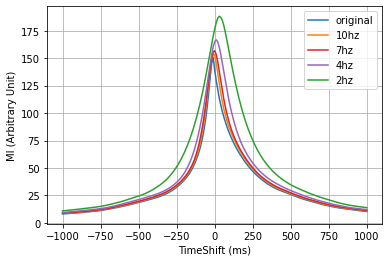

In [11]:
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    plt.plot(timeshift*1000,MI_set[i],color=colorlist[i]) 
    legend_list=[str(fc[j])+'hz' for j in range(len(fc))]
    legend_list.insert(0,'original')
#     plt.legend(('original','10hz','7hz','4hz','2hz'))
    plt.legend((legend_list))
    plt.xlabel('TimeShift (ms)')
    plt.ylabel('MI (Arbitrary Unit)')
plt.grid()
plt.show()
#     plt.xlim(-500,500)

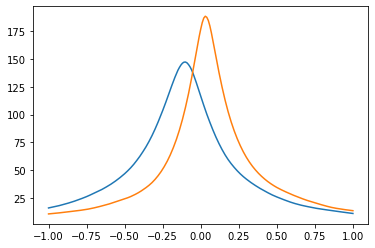

In [12]:
# without feedback
y0,z0=NGD(x_set[-1],8,1.4,37,10,0)
timeshift,MI0=MI(EqualState(x_set[0],8),EqualState(y0,8),dt,[-1,1])
plt.plot(timeshift,MI0)
plt.plot(timeshift,MI_set[-1])

In [13]:
# # NGD delayed feedback with constant tau
# tau_NGD=3
# y_set1=[[] for i in range(len(x_set))]
# z_set1=[[] for i in range(len(x_set))]
# for i in range(len(x_set)):
#     y_set1[i],z_set1[i]=NGD_const(x_set[i],10,tau_NGD,10)

# MI_set1=[[] for i in range(len(x_set))]
# for i in range(len(x_set)):
#     timeshift,MI_set1[i]=MI(EqualState(x_set[i],8),EqualState(y_set1[i],8),dt,[-5,5])
    
# for i in range(np.size(x_set,0)):
#     colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
#     plt.plot(timeshift*1000,MI_set1[i],color=colorlist[i])
#     plt.xlim()
#     plt.legend((legend_list))
# #     plt.legend(('original','10hz','7hz','4hz','2hz'))
#     plt.xlabel('TimeShift (ms)')
#     plt.ylabel('MI (Arbitrary Unit)')
#     plt.grid()
# #     plt.xlim(-500,500)

In [14]:
# # same scale
# for i in range(np.size(x_set,0)):
#     x_set[i]=x_set[i]/np.std(x_set[i])
#     y_set1[i]=y_set1[i]/np.std(y_set1[i])
#     z_set1[i]=z_set1[i]/np.std(z_set1[i])

# for i in range(np.size(x_set,0)):
#     plt.plot(T,x_set[i])
#     plt.plot(T,y_set1[i])
#     plt.plot(T,z_set1[i])
#     plt.xlim(200,250)
#     plt.show()

In [15]:
# path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200408/MIdata/'
# file=['20200408_OU_original_tau=0p5_sort_unit2_MI.mat','20200408_OU_cutoff=10_sort_unit2_MI.mat',\
#       '20200408_OU_cutoff=7_sort_unit2_MI.mat','20200408_OU_cutoff=4_sort_unit2_MI.mat',\
#      '20200408_OU_cutoff=2_sort_unit2_MI.mat']

path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
file=['OU_tau=100ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
      'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
     'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat']

# path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
# file=['OU_tau=1000ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
#       'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
#      'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat']

# path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
# file=['OU_tau=600ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
#       'OU_tau=600ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
#      'OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat']


MIlist=[[] for n in range(5)]
expdata=[0 for n in range(5)]
channel=38
for i in range(5):
    expdata=loadmat(path+file[i])
    MI_data=expdata['MI']
    TS=expdata['TimeShift']
    TS=TS[0]
    MIlist[i]=MI_data[0][channel][0]

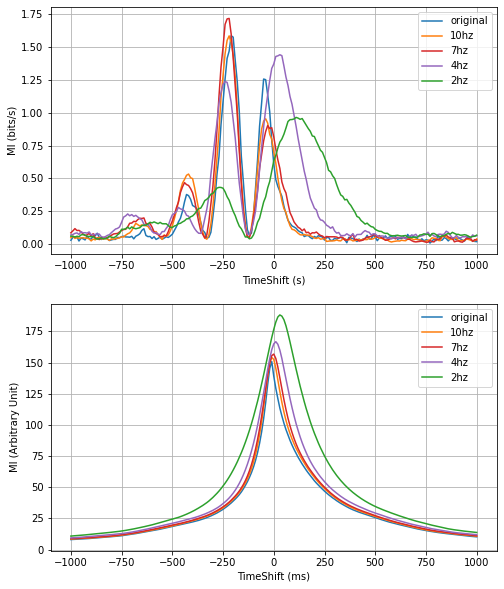

In [16]:
fig = plt.figure(figsize=(8,10))
ax1=fig.add_subplot(2,1,1)
for i in range(5):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    ax1.plot(TS,MIlist[i],color=colorlist[i])
    ax1.legend(('original','10hz','7hz','4hz','2hz'))
    ax1.set_xlabel('TimeShift (s)')
    ax1.set_ylabel('MI (bits/s)')
#     plt.xlim(-500,500)
ax1.grid()
    
ax2=fig.add_subplot(2,1,2)
for i in range(np.size(x_set,0)):
    colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
    ax2.plot(timeshift*1000,MI_set[i],color=colorlist[i])
    legend_list=[str(fc[j])+'hz' for j in range(len(fc))]
    legend_list.insert(0,'original')
#     plt.legend(('original','10hz','7hz','4hz','2hz'))
    ax2.legend((legend_list))
    ax2.set_xlabel('TimeShift (ms)')
    ax2.set_ylabel('MI (Arbitrary Unit)')
ax2.grid()

In [17]:
# find MI peak positions
# simulation
TSpeak_exp=np.zeros(len(MI_set))
TSpeak_sim=np.zeros(len(MI_set))
for i in range(len(MI_set)):
    loc=np.argmax(MI_set[i][timeshift>-0.1])
    TSpeak_sim[i]=timeshift[timeshift>-0.1][loc]*1000
    loc2=np.argmax(MIlist[i][TS>-100])
    TSpeak_exp[i]=TS[TS>-100][loc2]

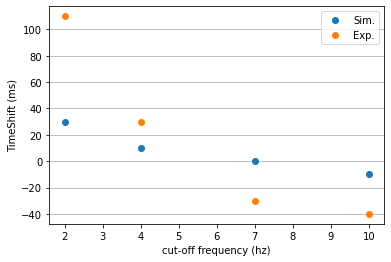

In [18]:
fc_x=np.array([float('inf'),10,7,4,2])  # 20 is not a actual number ; float('inf')
plt.plot(fc_x,TSpeak_sim,'o')
plt.plot(fc_x,TSpeak_exp,'o')
plt.grid(axis='y')
plt.ylabel('TimeShift (ms)')
plt.xlabel('cut-off frequency (hz)')
plt.legend(('Sim.','Exp.'))

(0.0, 50.0)

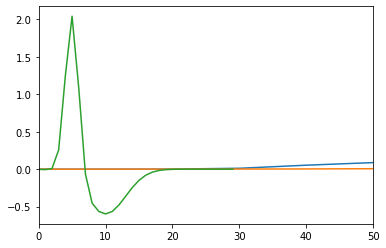

In [19]:
# temporal kernel
t=np.arange(0,300,10)
k1 = 2.2
sigma_1 = 10
u1 = 50
k2 = 1.8
sigma_2 = 30
u2 = 100
kernel1 = (k1/np.sqrt(2*np.pi)/sigma_1)*np.exp(-(t-u1)**2/(2*sigma_1**2))
kernel2 = (k2/np.sqrt(2*np.pi)/sigma_2)*np.exp(-(t-u2)**2/(2*sigma_2**2))
k=(kernel1-kernel2)
k=k/sum(k)
plt.plot(t,kernel1)
plt.plot(t,kernel2)
plt.plot(k)
plt.xlim(0,50)

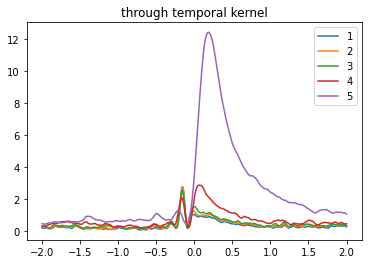

Text(0.5, 1.0, 'no temporal kernel')

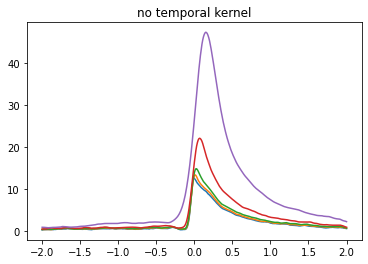

In [20]:
# cone output through a temporal filter
y_set_new=[[] for i in range(len(x_set))]
z_set_new=[[] for i in range(len(x_set))]
for i in range(len(x_set)):
    y_set_new[i],z_set_new[i]=NGD(x_set[i],20,1.6,50,10,1)

y_filt_set=[[] for k in range(len(y_set_new))]
MI_filt_set=[[] for k in range(len(y_set_new))]
for i in range(len(y_set_new)):
    y_filt_set[i]=np.convolve(y_set_new[i],k,'valid')
    TS_filt,MI_filt_set[i]=MI(EqualState(x_set[i][len(k)-1:],8),EqualState(y_filt_set[i],8),0.01,[-2,2])
    plt.plot(TS_filt,MI_filt_set[i])
plt.legend(('1','2','3','4','5'))
plt.title('through temporal kernel')
plt.show()
MI_set_new=[[] for k in range(len(y_set_new))]
for i in range(len(y_set_new)):
    TS_new,MI_set_new[i]=MI(EqualState(x_set[i],8),EqualState(y_set_new[i],8),0.01,[-2,2])
    plt.plot(TS_new,MI_set_new[i])
plt.title('no temporal kernel')

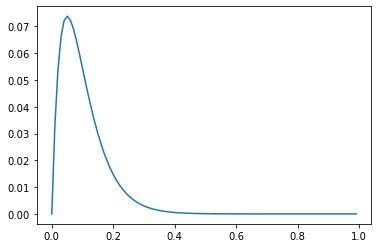

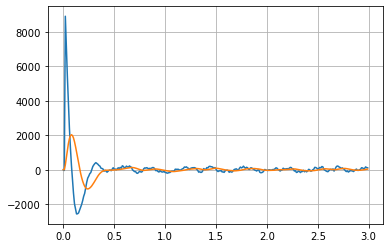

In [21]:
# calculate the equivalent temporal kernel
dt=0.01
T=np.arange(dt,300,dt)
mu, sigma = 0, 1 # mean and standard deviation
x_ori = np.random.normal(mu, sigma, len(T))
t_k=np.arange(0,100)*dt
tau_x=0.05
kx=t_k*np.exp(-t_k/tau_x)/tau_x**2
kx=kx/np.sum(kx)
plt.plot(t_k,kx)
plt.show()

x_delay=np.convolve(x_ori,kx,'valid')
alpha1,beta1,K1,g1=20,1.6,30,10
y_ori,z_ori=NGD(x_ori,alpha1,beta1,K1,g1,1)
y_convolved,z_convolved=NGD(x_delay,alpha1,beta1,K1,g1,1)

corr1=np.correlate(x_ori,y_ori,'same')
corr2=np.correlate(x_ori[len(kx)-1:],y_convolved,'same')

plt.plot(np.arange(0,300)*dt,corr1[round((len(corr1))/2):round((len(corr1))/2-300):-1])
plt.plot(np.arange(0,300)*dt,corr2[round((len(corr2))/2):round((len(corr2))/2-300):-1])
plt.xlim()
plt.grid()
plt.show()


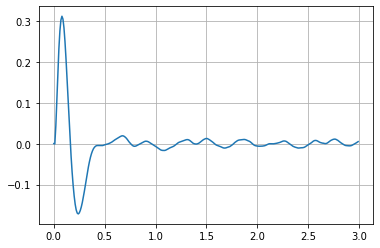

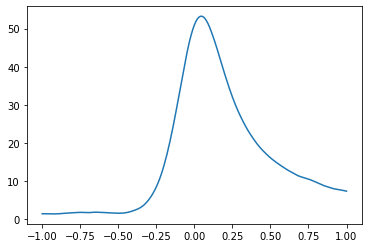

In [22]:
# use the equivalent temporal kernel to generate the output
dt=0.01
t_tempk=np.arange(0,300)*dt
equi_temp_k=corr2[round((len(corr2))/2):round((len(corr2))/2-300):-1]
equi_temp_k=equi_temp_k/np.sqrt(sum(equi_temp_k**2))
plt.plot(t_tempk,equi_temp_k)
plt.grid()
plt.show()

y_equi_temp_k=np.convolve(x_set[-1],equi_temp_k,'valid')
TS_temp_k,MI_temp_k=MI(EqualState(x_set[-1][len(equi_temp_k)-1:],8),EqualState(y_equi_temp_k,8),0.01,[-1,1])
plt.plot(TS_temp_k,MI_temp_k)

In [23]:
print(len(x_set[-1][len(equi_temp_k)-1:]),len(y_equi_temp_k))
print(x_set[-1][len(equi_temp_k)-1:],y_equi_temp_k)

29700 29700
[ 1.6729582   1.69453944  1.71866206 ... -1.14118569 -1.13002376
 -1.11977144] [ 1.18674392  1.16524133  1.14934529 ... -0.90081348 -0.8853256
 -0.86822548]


(10000.0, 12000.0)

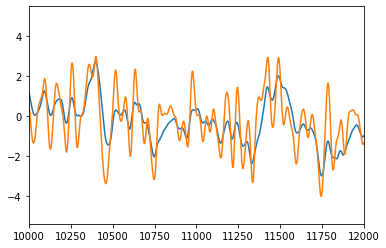

In [24]:
plt.plot(x_set[-1][len(equi_temp_k)-1:])
plt.plot(y_equi_temp_k)
plt.xlim(10000,12000)

In [25]:
import numpy as np
from random import gauss
from math import sqrt
import matplotlib as mpl
mpl.use('nbagg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# generate the HMM signal

G_HMM = 1; 
D_HMM = 2.7e6;     #dynamical range
nstep = 20000
dt = 0.05

# HMM model parameters
#    G_HMM = 4; 
#    D_HMM = 2700000;     #dynamical range
omega =G_HMM/2.12;        # omega = G/(2w)=1.06; follow Bialek's overdamped dynamics/ 2015PNAS

# generate the stochastic sequence in x
x = np.zeros(nstep)
v = np.zeros(nstep)
x[0] = 0.0
v[0] = 0.0
for i in range(1,nstep):
        x[i] = x[i-1] + v[i-1]*dt
        v[i] = (1-G_HMM*dt)*v[i-1]-omega**2*x[i-1]*dt + gauss(0,1)*np.sqrt(D_HMM*dt)


In [27]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [28]:
y=np.convolve(x,equi_temp_k,'valid')

In [29]:
xx = x[len(equi_temp_k)-1:]

In [30]:
len(xx)-len(y)

0

In [31]:
dms = range(-199,200)

mi_xxx = [mi_quick(xx,xx,d) for d in dms]
mi_xxy = [mi_quick(xx,y,d) for d in dms]

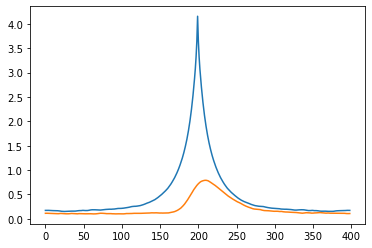

In [32]:
plt.plot(mi_xxx)
plt.plot(mi_xxy)